# Step 2: Add SageMaker processing and training jobs
In this step you move data processing and model training into [SageMaker Docker containers](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html) and use [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to interact with SageMaker.

![](img/six-steps-2.png)

SageMaker makes use of Docker containers to enable developers to process data, train and deploy models. Containers allow developers and data scientists to package software into standardized units that run consistently on any platform that supports Docker. Containers ensure taht code, runtime, system tools, system libraries, and settings are all in the same place, isolating them from the execution environment. It guarantees a consistent runtime experience regardless of where a container is being run.

SageMaker also provides pre-build containers with popular data processing frameworks and ML algorithms. All SageMaker built-in algorithms are delivered as Docker containers.

In [ ]:
import time

import boto3
import numpy as np  
import pandas as pd  
import sagemaker
from time import gmtime, strftime, sleep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sklearn.metrics import roc_auc_score

sagemaker.__version__

In [ ]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

## Process data
Use [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) by simply providing a Python data preprocessing script and choosing a [SageMaker SDK processor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html) class.
You must upload the input data to S3 and specify an S3 location for output data. SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a Processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes.

![](img/sagemaker-processing.png)

Your input data must be stored in an Amazon S3 bucket. Alternatively, you can use Amazon Athena or Amazon Redshift as input sources.

Upload the input dataset to an Amazon S3 bucket:

In [ ]:
session = sagemaker.Session()

In [ ]:
input_s3_url = session.upload_data(
    path="data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)

%store input_s3_url

In [ ]:
!aws s3 ls {bucket_name}/{bucket_prefix} --recursive

Create a Python script by moving the data processing code from the step 1 notebook to a .py file:

In [ ]:
%%writefile preprocessing.py

import pandas as pd
import numpy as np
import argparse
import os

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()


if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    
    target_col = "y"
    
    # Load data
    df_data = pd.read_csv(os.path.join(args.filepath, args.filename), sep=";")

    # Indicator variable to capture when pdays takes a value of 999
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

    # Indicator for individuals not actively employed
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # remove unnecessary data
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

    # Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
    df_model_data = pd.concat(
        [
            df_model_data["y_yes"].rename(target_col),
            df_model_data.drop(["y_no", "y_yes"], axis=1),
        ],
        axis=1,
    )

    # Shuffle and splitting dataset
    train_data, validation_data, test_data = np.split(
        df_model_data.sample(frac=1, random_state=1729),
        [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
    )

    print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
    # Save datasets locally
    train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    
    print("## Processing complete. Exiting.")

Set the Amazon S3 paths:

In [ ]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"

%store baseline_s3_url
%store train_s3_url

In [ ]:
framework_version = "0.23-1"
processing_instance_type = "ml.m5.large"
processing_instance_count = 1

Instantiate a [`SKLearnProcessor`](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) object before starting the SageMaker processing job. You specify the instance type to use in the job, as well as how many instances for distributed processing.

Note how SageMaker maps your data to the local paths on the processing container's EBS volume:

![](img/data-processing.png)

In [ ]:
sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    role=sm_role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count, 
    base_job_name='from-idea-to-prod-processing',
    sagemaker_session=session,
)

Define processing inputs and outputs:

In [ ]:
processing_inputs = [
        ProcessingInput(
            source=input_s3_url, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url
        ),
    ]

Start the SageMaker processing job:

In [ ]:
sklearn_processor.run(
    inputs=processing_inputs,
    outputs=processing_outputs,
    code='preprocessing.py',
    # arguments = ['arg1', 'arg2'],
)

In [ ]:
!aws s3 ls {bucket_name}/{bucket_prefix} --recursive

## Model training
Follow the same approach and now run the model training as a [SageMaker training job](https://sagemaker.readthedocs.io/en/stable/overview.html#using-estimators).

In [ ]:
# get training container uri
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")

print(training_image)

Define the data input channels for the training job. Set _train_ and _validation_ channels via the SageMaker SDK [`TrainingInput`](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class:

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(train_s3_url, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(validation_s3_url, content_type='csv')

In [ ]:
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

# Define where the training job stores the model artifact
output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

%store output_s3_url

Instantiate an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object and set algorithm's hyperparameters. Refer to [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for more information.

In [ ]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    # use_spot_instances=True,  # Use spot instances to reduce cost
    # max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150, # the number of rounds to run the training
    max_depth=5, # maximum depth of a tree
    eta=0.5, # step size shrinkage used in updates to prevent overfitting
    alpha=2.5, # L1 regularization term on weights
    objective="binary:logistic",
    eval_metric="auc", # evaluation metrics for validation data
    subsample=0.8, # subsample ratio of the training instance
    colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
    min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
    early_stopping_rounds=10, # the model trains until the validation score stops improving
    verbosity=1, # verbosity of printing messages
)

Run the training:

In [ ]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

In [ ]:
estimator.fit(
    training_inputs,
    #wait=False
) 

### Reduce training job startup time with warm pools
💡 Instead of using each time a new ephemeral computation cluster to train your models, you can keep your model training hardware instances warm after every job for a specified period. Refer to [Reduce ML Model Training Job startup time by up to 8x using SageMaker Training Managed Warm Pools](https://aws.amazon.com/about-aws/whats-new/2022/09/reduce-ml-model-training-job-startup-time-8x-sagemaker-training-managed-warm-pools/) for more details. If you opt to use warm pools, you are billed for the instances and EBS volumens for the duration of the keep-alive period. 
Refer to [ Train Using SageMaker Managed Warm Pools](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) in the Amazon SageMaker Developer Guide for details on training API.

In [ ]:
if estimator._current_job_name:
    training_job_name = estimator._current_job_name

Output model performance:

In [ ]:
metrics = boto3.client("sagemaker", region_name=region).describe_training_job(
    TrainingJobName=training_job_name
    )["FinalMetricDataList"]

train_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'train:auc'][0])
validate_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'validation:auc'][0])

print(f"Train-auc:{train_auc:.2f}, Validate-auc:{validate_auc:.2f}")

In [ ]:
%store training_job_name

In [ ]:
# Print the S3 path to the model artifact:
estimator.model_data

## Validate model
The training job saved a model in the specified location on Amazon S3.

You can deploy the model as a [real-time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html), which is just one [function call](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy), or create a [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict a label for a large dataset.

### Real-time inference
To test [real-time inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) you create a real-time endpoint using the trained estimator.

In [ ]:
# Real-time endpoint:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    # wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
    # Turn on data capture here, in case you want to experiment with monitoring:
    data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
        enable_capture=True,
        sampling_percentage=100,
        destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
    ),
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

#### Predict

In [ ]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

In [ ]:
test_x = pd.read_csv("tmp/test_x.csv", names=[f'{i}' for i in range(59)])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

In [ ]:
predictions = np.array(predictor.predict(test_x.values), dtype=float).squeeze()
predictions

#### Evaluate predictions

In [ ]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_x.index),
        test_x,
    ],
    axis=1,
)
test_results.head()

In [ ]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

In [ ]:
test_auc = roc_auc_score(test_y, test_results["y_pred"])
print(f"Test-auc: {test_auc:.2f}")

### Batch transform
If you want to run a prediction on a large dataset or don't need a real-time endpoint, you can use SageMaker [batch-transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html).

In [ ]:
transform_s3_url = f"s3://{bucket_name}/{bucket_prefix}/transform"
transform_job_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"
model_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"
model_name

To create a transformer, use either option 1 or option 2.

#### Option 1: create a batch transformer from the trained estimator
You can use [`EstimatorBase.transformer()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer) to create a transformer for an estimator:

In [ ]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    role=sm_role,
    output_path=transform_s3_url,
    model_name=model_name,
)

Go to the section **Run transform job**.

#### Option 2: load a model from a training job
Alternatively, you can load a model from a model artifact produced by a training job. You create a transformer with that model.

In [ ]:
model = session.create_model_from_job(
    training_job_name=training_job_name, 
    name=model_name,
)

In [ ]:
transformer = sagemaker.transformer.Transformer(
    model_name=model,
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    assemble_with="Line",
    output_path=transform_s3_url,
    base_transform_job_name="from-idea-to-prod-trasform",
    sagemaker_session=session,
)

#### Run transform job

In [ ]:
transformer.transform(    
    data=f"{test_s3_url}/test_x.csv",
    content_type="text/csv",
    split_type="Line", 
    job_name=transform_job_name,
    wait=True,
)

In [ ]:
transformer.output_path

#### Evaluate predictions

In [ ]:
!aws s3 ls {transformer.output_path}/

In [ ]:
!aws s3 cp {transformer.output_path}/test_x.csv.out tmp/predictions.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

In [93]:
predictions = pd.read_csv("tmp/predictions.csv", names=["y_prob"])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

In [94]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.array(np.round(predictions), dtype=float).squeeze(), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3594,42
1,388,95


In [95]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.2f}")

Test-auc: 0.77


#### ROC curve

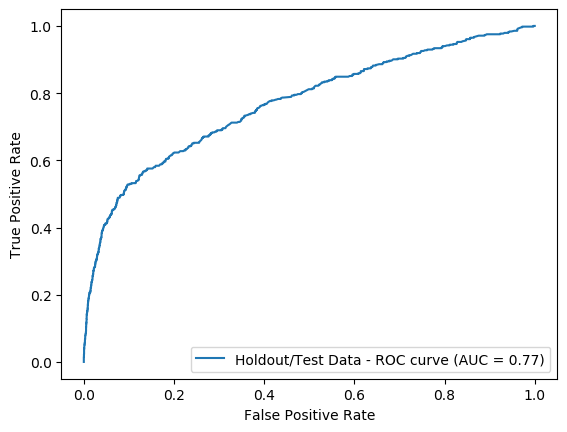

In [101]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Holdout/Test Data - ROC curve')
display.plot()
plt.show()

#### Confusion matrix

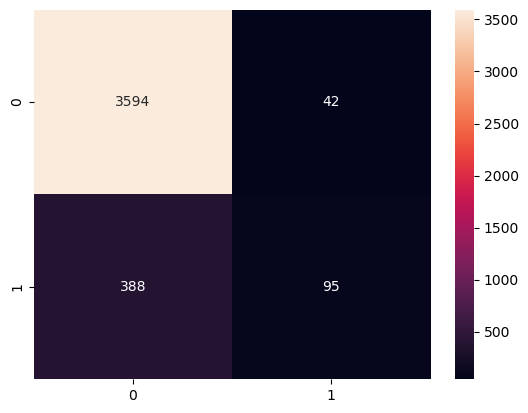

In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, np.round(predictions))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#### Precision-recall curve

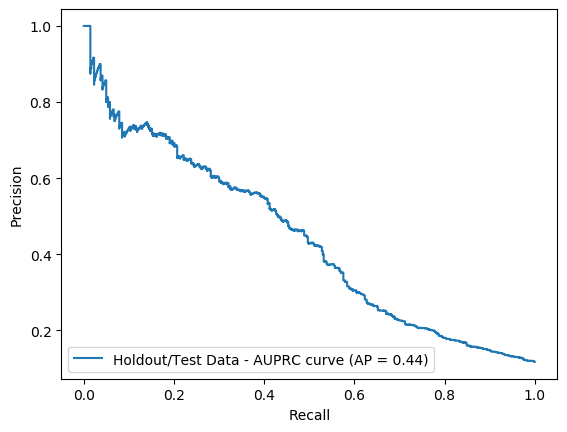

In [104]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_y, predictions)
average_precision= metrics.average_precision_score(test_y, predictions)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Holdout/Test Data - AUPRC curve')
pr_display.plot()
plt.show()

---

## Optional: Hyperparameter Optimization (HPO)
It takes about 30 minutes to run this section. The section is optional. You don't need to run it to continue with other notebooks. You can navigate directly to step 3 [notebook](03-sagemaker-pipeline.ipynb).

[Amazon SageMaker automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), also called hyperparameter optimization (HPO), finds the best performing model against a defined objective metric by running many training jobs on the dataset using the algorithm and ranges of hyperparameters that you specify. SageMaker HPT supports random search, bayesian optimization, and [hyperband](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) as tuning strategies.

In [ ]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [ ]:
# set up hyperparameter ranges
hp_ranges = {
    "min_child_weight": ContinuousParameter(1, 10),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
}

# set up the objective metric
objective = "validation:auc"

# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=estimator,  # the SageMaker estimator object
    hyperparameter_ranges=hp_ranges,  # the range of hyperparameters
    max_jobs=20,  # total number of HPO jobs
    max_parallel_jobs=2,  # how many HPO jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",  # maximize or minimize the objective metric
    base_tuning_job_name="from-idea-to-prod-hpo",
    early_stopping_type="Auto",
)

Now run the HPO job. It takes about 20 minutes to complete.

In [ ]:
tuner.fit({"train": s3_input_train, "validation": s3_input_validation})

In [ ]:
print(f"HPO job status: {boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']}")

In [ ]:
hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

In [ ]:
hpo_predictions = np.array(hpo_predictor.predict(test_x.values), dtype=float).squeeze()
print(hpo_predictions)

In [ ]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(hpo_predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

---

## Clean-up
To avoid charges, remove the hosted endpoint you created.

In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)

In [ ]:
# run if you created a tuned predictor after HPO
hpo_predictor.delete_endpoint(delete_endpoint_config=True)

## Continue with the step 3
open the step 3 [notebook](03-sagemaker-pipeline.ipynb).

## Further development ideas for your real-world projects
- Track, organize, and compare all your model training runs using [SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html)
- Use [Amazon SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) for creating a no-code or low-code visual data processing and feature engineering flow. Refer to this hands-on tutorial: [Prepare Training Data for Machine Learning with Minimal Code](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-prepare-data-with-minimal-code/)

## Additional resources
- [Using Docker containers with SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html)
- [How to create and use a custom SageMaker container: SageMaker hands-on workshop](https://sagemaker-workshop.com/custom/containers.html)
- [Amazon SageMaker Immersion Day](https://catalog.us-east-1.prod.workshops.aws/workshops/63069e26-921c-4ce1-9cc7-dd882ff62575/en-US)
- [Targeting Direct Marketing with Amazon SageMaker XGBoost](https://github.com/aws-samples/amazon-sagemaker-immersion-day/blob/master/processing_xgboost.ipynb)
- [Train a Machine Learning Model](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-train-a-model/)
- [Deploy a Machine Learning Model to a Real-Time Inference Endpoint](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-deploy-model-to-real-time-inference-endpoint/)
- [Amazon SageMaker 101 Workshop](https://catalog.us-east-1.prod.workshops.aws/workshops/0c6b8a23-b837-4e0f-b2e2-4a3ffd7d645b/en-US)
- [Amazon SageMaker 101 Workshop code repository](https://github.com/aws-samples/sagemaker-101-workshop)
- [Amazon SageMaker with XGBoost and Hyperparameter Tuning for Direct Marketing predictions](https://github.com/aws-samples/sagemaker-101-workshop/blob/main/builtin_algorithm_hpo_tabular/SageMaker%20XGBoost%20HPO.ipynb)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>